In [1]:
import os
import sys
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from pathlib import Path
from datetime import datetime

from model_settings import ms
from feature_collector import collect_features

os.chdir(os.path.abspath(str(Path())))
pd.set_option("display.max_columns",None)
pd.options.display.float_format = '{:.5f}'.format
notebook_dir = str(Path().resolve())
root = Path().resolve().parent.parent
models_dir = os.path.join(root,ms.trained_models)

# initializing

In [2]:
from convsklearn import barrier_trainer, asian_trainer
price_name = 'barrier_price' 
filetag = 'cboe barriers'
trainer = barrier_trainer
datadir = os.path.join(root,ms.cboe_spx_barriers['dump'])

dataset = collect_features(datadir,price_name)


train_start = time.time()
train_start_datetime = datetime.fromtimestamp(train_start)
train_start_tag = train_start_datetime.strftime('%c')
print("\n"+"#"*18+"\n# training start #\n"+
      "#"*18+"\n"+f"\n{train_start_tag}\n")

100%|███████████████████████████████████████████████████████████████████████████████| 586/586 [00:03<00:00, 148.20it/s]



##################
# training start #
##################

Thu Oct 31 23:20:54 2024



# preprocessing

## train/test split

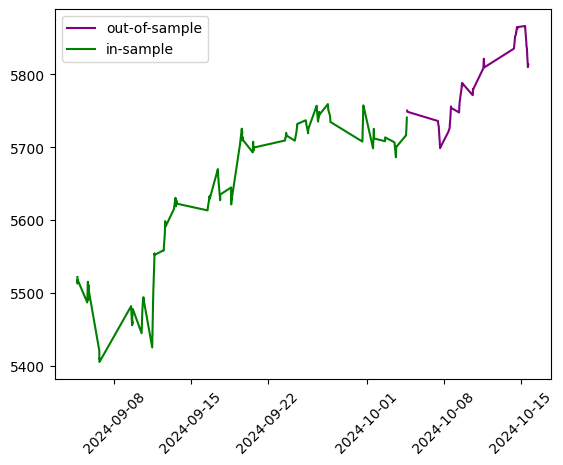

911088 306323


In [3]:
dates = pd.Series(np.sort(dataset['calculation_date'].unique()))
development_dates = dates[:len(dates)*3//4]
# development_dates = dates[dates<=pd.Timestamp(2008,8,1)]
test_dates = dates[~dates.isin(development_dates)]
train_data = dataset[dataset['calculation_date'].isin(development_dates)]
test_data = dataset[dataset['calculation_date'].isin(test_dates)]

train_plot = train_data[['calculation_date','spot_price']].copy().set_index('calculation_date').drop_duplicates()
test_plot = test_data[['calculation_date','spot_price']].copy().set_index('calculation_date').drop_duplicates()
plt.figure()
plt.xticks(rotation=45)
plt.plot(test_plot,color='purple',label='out-of-sample')
plt.plot(train_plot,color='green',label='in-sample')
plt.legend()
plt.show()
arrs = trainer.get_train_test_arrays(
    train_data, test_data)
train_X = arrs['train_X']
train_y = arrs['train_y']
test_X = arrs['test_X']
test_y = arrs['test_y']
preprocessor = trainer.preprocess()
print(len(train_y),len(test_X))

In [4]:
model_fit = trainer.run_dnn(preprocessor,train_X,train_y)
train_test = trainer.test_prediction_accuracy(train_data,test_data,model_fit)
train_data = train_test['train_data']
test_data = train_test['test_data']


training...

alpha: 0.01
hidden_layer_sizes: (13, 13)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001
cpu: 142.65862202644348

in sample:
     RMSE: 247.91754714323872
     MAE: 188.05504586606511

out of sample:
     RMSE: 246.4146983267973
     MAE: 193.23874924093369


# saving

In [5]:
train_end = time.time()
train_end_tag = str(datetime.fromtimestamp(
    train_end).strftime("%Y_%m_%d %H%M%S%f"))
file_tag = str(train_end_tag + " " + filetag)
files_dir = os.path.join(models_dir,file_tag)

def save_model():
    if Path(files_dir).exists():
        pass
    else:
        os.mkdir(files_dir)
    file_dir = os.path.join(files_dir,file_tag)
    S = np.sort(train_data['spot_price'].unique())
    K = np.sort(train_data['strike_price'].unique())
    T = np.sort(train_data['days_to_maturity'].unique())
    W = np.sort(train_data['w'].unique())
    n_calls = train_data[train_data['w']=='call'].shape[0]
    n_puts = train_data[train_data['w']=='put'].shape[0]
    train_data.to_csv(f"{file_dir} train_data.csv")
    test_data.to_csv(f"{file_dir} test_data.csv")
    joblib.dump(model_fit,str(f"{file_dir}.pkl"))
    pd.set_option("display.max_columns",None)
    print(f"model saved to {file_dir}")

print(f"execute the command 'save_model()' to save the following model: {file_tag}")
train_runtime = train_end-train_start
print(f"\ncpu: {train_runtime}")

execute the command 'save_model()' to save the following model: 2024_10_31 232318077842 cboe barriers

cpu: 143.97358632087708
